In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# Change this to your own path inside Google Drive
base_dir = '/content/drive/MyDrive/Lung Disease Dataset'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import random


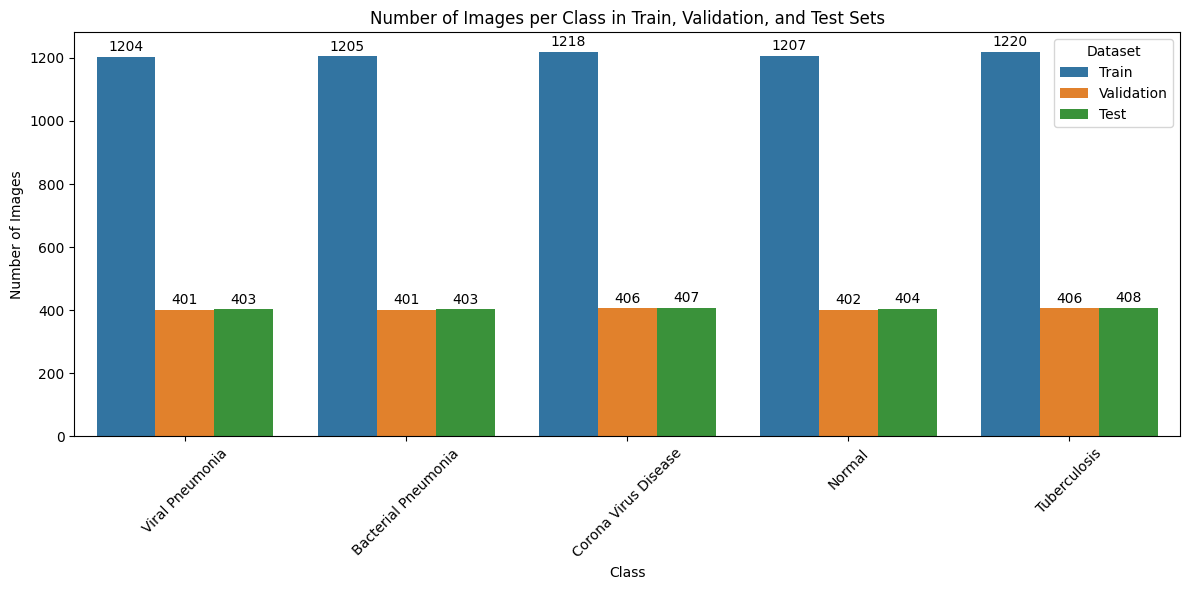

In [4]:

# Function to count images inside each folder
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Combine into a single DataFrame
all_data = []

for cls, count in train_counts.items():
    all_data.append({'Class': cls, 'Set': 'Train', 'Images': count})
for cls, count in val_counts.items():
    all_data.append({'Class': cls, 'Set': 'Validation', 'Images': count})
for cls, count in test_counts.items():
    all_data.append({'Class': cls, 'Set': 'Test', 'Images': count})

df_all = pd.DataFrame(all_data)

# Now plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Class', y='Images', hue='Set', data=df_all)

# Add labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)

plt.title('Number of Images per Class in Train, Validation, and Test Sets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


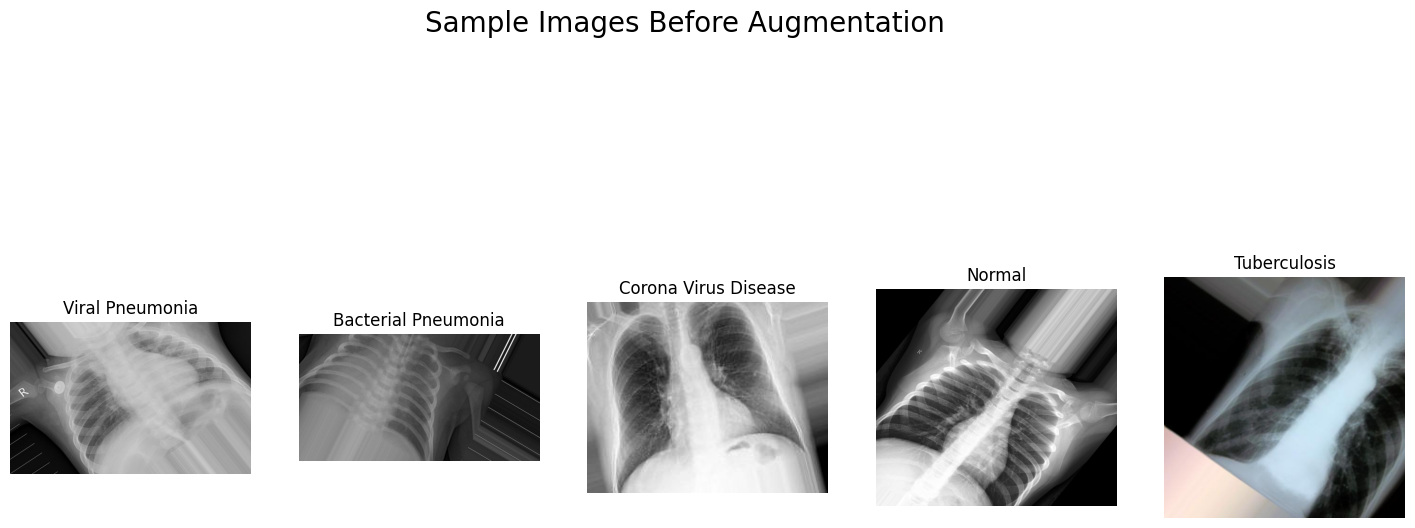

In [5]:
# Function to show random images from each class
def show_images(directory, title):
    plt.figure(figsize=(18, 8))
    class_names = os.listdir(directory)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.suptitle(title, fontsize=20)
    plt.show()

# Show images
show_images(train_dir, 'Sample Images Before Augmentation')


In [6]:
# Data augmentation settings
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,

)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [7]:
img_size = (240, 240)  # You can adjust depending on your model

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


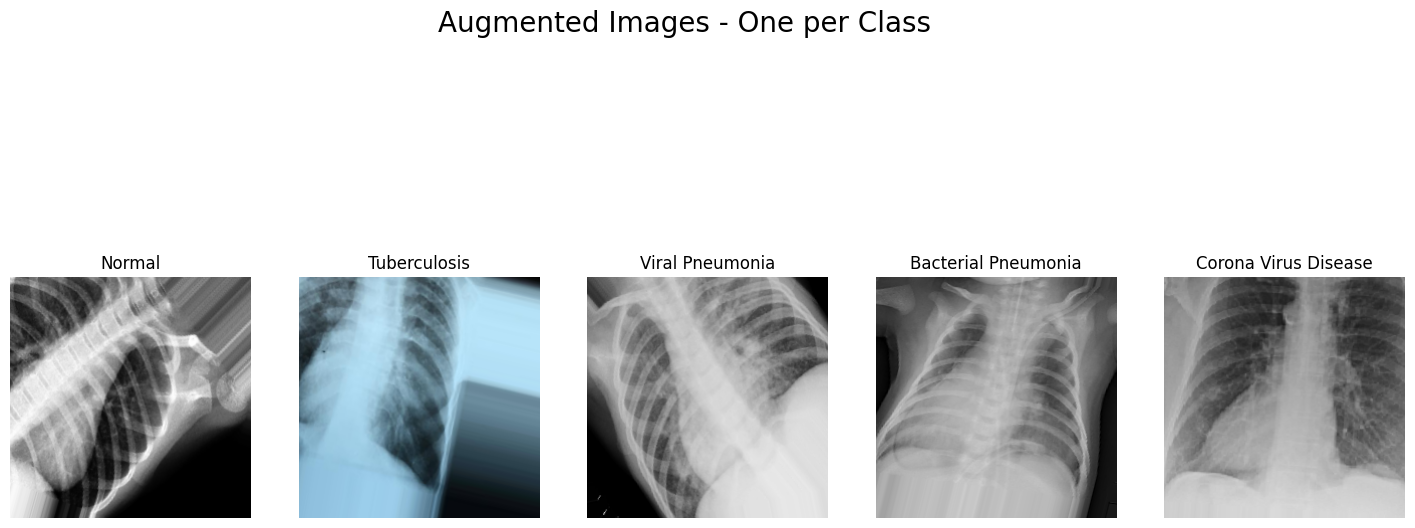

In [8]:
# Function to plot 1 augmented image from each class separately
def plot_augmented_images_per_class(generator):
    class_indices = generator.class_indices
    class_labels = list(class_indices.keys())
    images_per_class = {}

    # Try to collect one sample per class
    while len(images_per_class) < len(class_labels):
        images, labels = next(generator)
        for img, label in zip(images, labels):
            class_idx = np.argmax(label)
            class_name = class_labels[class_idx]
            if class_name not in images_per_class:
                images_per_class[class_name] = img
            if len(images_per_class) == len(class_labels):
                break

    # Plot
    plt.figure(figsize=(18, 8))
    for idx, (class_name, img) in enumerate(images_per_class.items()):
        plt.subplot(1, len(class_labels), idx+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.suptitle('Augmented Images - One per Class', fontsize=20)
    plt.show()

# Now call the function
plot_augmented_images_per_class(train_generator)


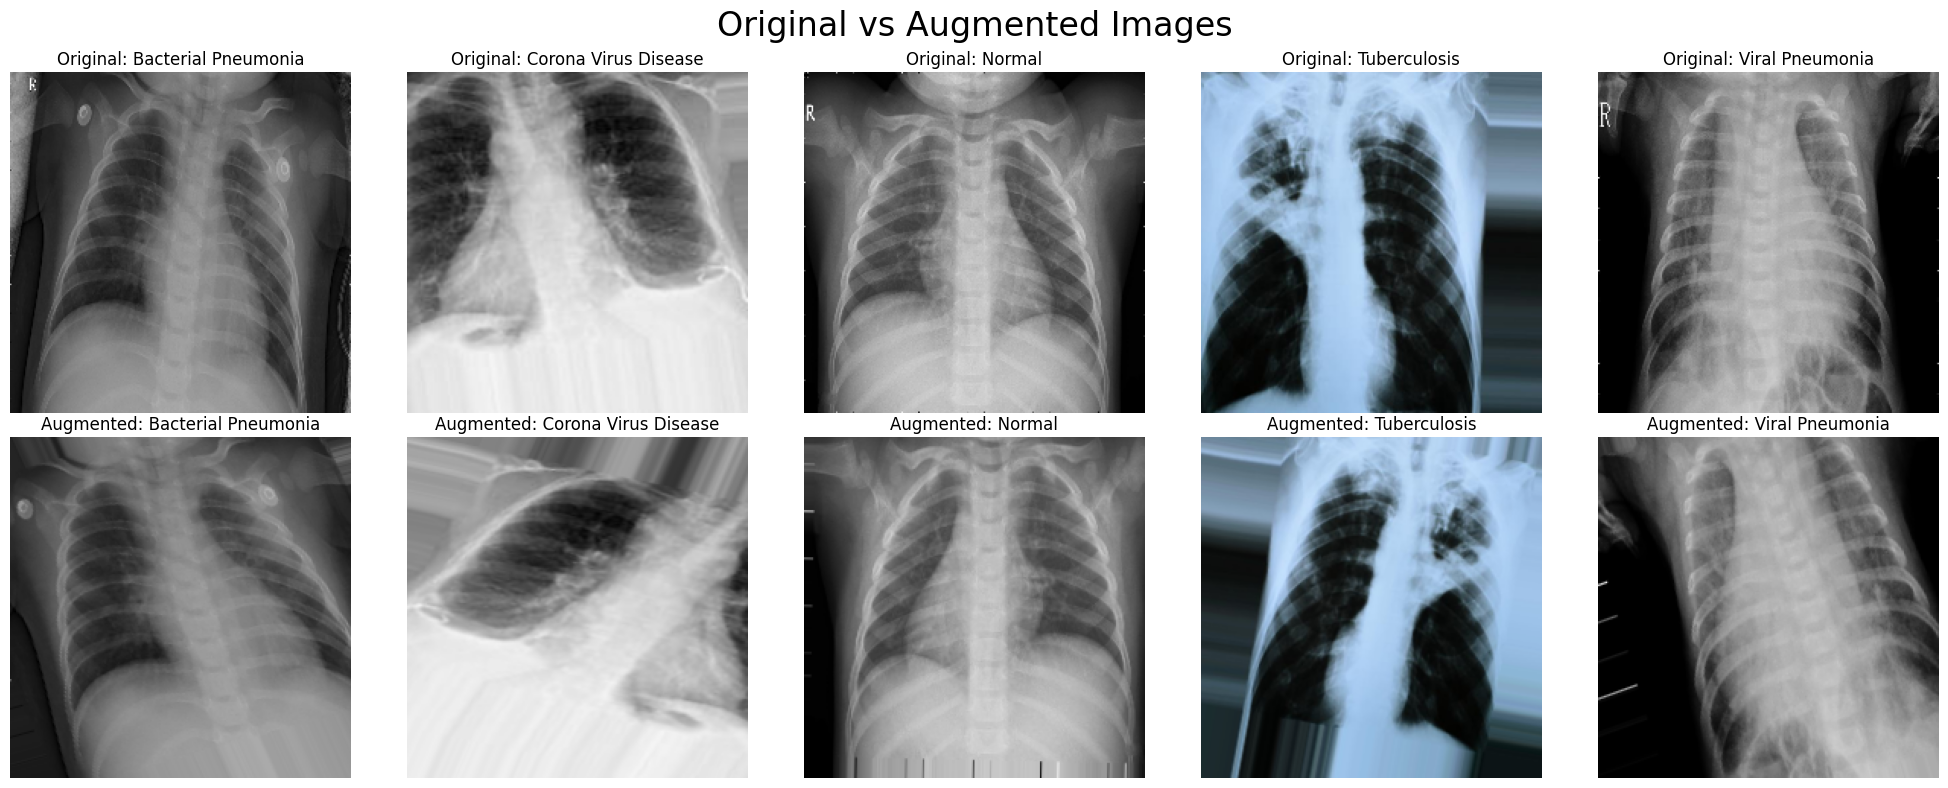

In [9]:
# Function to display original and augmented images side-by-side for each class
def show_before_after(directory, generator, num_classes=5):
    class_labels = os.listdir(directory)
    class_labels.sort()  # Ensure sorted order

    plt.figure(figsize=(20, 8))

    for idx, class_name in enumerate(class_labels[:num_classes]):
        # Pick random original image
        class_path = os.path.join(directory, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (224, 224))

        # Get augmented image
        augmented_img = generator.random_transform(img_resized)

        # Plot Original
        plt.subplot(2, num_classes, idx+1)
        plt.imshow(img_resized)
        plt.title(f'Original: {class_name}')
        plt.axis('off')

        # Plot Augmented
        plt.subplot(2, num_classes, idx+1+num_classes)
        plt.imshow(augmented_img)
        plt.title(f'Augmented: {class_name}')
        plt.axis('off')

    plt.suptitle('Original vs Augmented Images', fontsize=24)
    plt.tight_layout()
    plt.show()

# Call the function
show_before_after(train_dir, train_datagen)
